# Plotting Fisher predictions for $\Delta\alpha$ against numerical simulations

Import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import arviz as az
from sympy.parsing import mathematica as M


%matplotlib inline
np.random.seed(1234)

az.style.use("arviz-darkgrid")

# Nice plotting options.

params = {'axes.labelsize': 14,
          'font.size': 14,
          'axes.linewidth': 1,
          'legend.fontsize': 11,
          'xtick.labelsize': 14,
          'xtick.top': True,
          'ytick.labelsize': 14,
          'ytick.right': True,
          'axes.grid' : True,
          'savefig.dpi' : 100,
          'lines.markersize' : 4,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

# LaTeX rendering.

from matplotlib import rc
rc('text', usetex=True)

We define some true parameters that we'll need.

In [2]:
"""
Parameters
"""

# Inputs to get the true ln M distribution.
# Notice that M runs from 10^4 to 10^7 in GTV.

alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. 
M_max=10000000.

### Fisher predictions

For this exercise, we use the expression for $\Delta\alpha$ obtained retaining the first term in the integral only, when no selection effects are present.

In [3]:
from sympy.parsing import mathematica as M
Dalpha_simpified = M.mathematica('Sqrt[1/(Nobs*(alpha^(-2) - (Mmax^alpha*Mmin^alpha*(Log[Mmax] - Log[Mmin])^2)/(Mmax^alpha - Mmin^alpha)^2))]')

def Dalpha(Nobs,alpha,Mmin,Mmax):
    
    out = Dalpha_simpified.subs([('Nobs',Nobs),('alpha',alpha),('Mmax',Mmax),('Mmin',Mmin)]).evalf()
    
    return float(out)

print('Analytical expression for the variance on the spectral index:')
Dalpha_simpified

Analytical expression for the variance on the spectral index:


sqrt(1/(Nobs*(-Mmax**alpha*Mmin**alpha*(log(Mmax) - log(Mmin))**2/(Mmax**alpha - Mmin**alpha)**2 + alpha**(-2))))

We create a list of $\Delta\alpha$ as a function of $N_\text{obs}$

In [4]:
# List without selection effects.

Da_list =[]
for N in range(1,110):
    Da_list.append(Dalpha(N,alpha0_t,M_min,M_max))
    
# List with selection effects.

Da_list_sel =[]
for N_det in range(1,110):
    Da_list_sel.append(np.sqrt(106/(N_det*86.39531326294203)))

### MCMC analyses without selection effects

Generate a set of $N_{\rm obs}$ observations, and then split this in such a way to have repetitions of $M_{\rm obs}$ observations. 

In [5]:
import emcee
import seaborn as sns

In [6]:
"""
Parameters
"""

N_obs = 200
N_samp_per_obs = 10

logM_min = np.log(M_min)
logM_max = np.log(M_max)

In [7]:
def model(lnM,alpha):
    
    M = np.exp(lnM) # mass observations
    norm  = alpha/(M_max**alpha-M_min**alpha)
    
    return norm*M**(alpha-1)

In [8]:
sigma = 0.1
noise = np.random.normal(0,sigma,size = N_obs)

"""
Data draws before chunks.
"""
u = np.random.uniform(size=N_obs)
logM_t=alpha0_t**-1 * np.log((M_max**(alpha0_t)-M_min**(alpha0_t))*u+ M_min**(alpha0_t)*np.ones(N_obs))
d_i = noise + logM_t 

Function to get the MCMC widths without selection effects given some data.

In [9]:
# Limits of (flat) hyperpriors.

N_samps_likelihoods = 10
N_samps_selfunction = 10000

# Limits of (flat) hyperpriors.

hyperprior_min = -100.0
hyperprior_max = 100.0

# Iterations, ndims and walkers.

n_iter = 10000
ndim = 1; nwalkers = 4

burnin = 1500
pos_init0 = [alpha0_t]


In [10]:
from MCMC_PowerLaw   import * # Import utils to perform the MCMC analysis.


def data_chunks(M_obs):
    
    #Generate data
    d_i = noise + logM_t 
    #Prepare chunks of data by dividing full length by M_obs
    chunked_data = [d_i[i:i + M_obs] for i in range(0, len(d_i), M_obs)]
    
    data_list = []
    for element in chunked_data:
        
        data=np.zeros((M_obs,N_samp_per_obs))
        for i in np.arange(M_obs):
            data[i,:]=np.random.normal(element[i],sigma,size=N_samp_per_obs)
            
    
        data_list.append(data)
    
    return data_list

def MCMC_width_nosel(data,M_obs):
    p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_nosel,
                                args=[data,hyperprior_min,hyperprior_max,
                                      M_max, M_min, sigma, M_obs]
                               )
    run = sampler.run_mcmc(p0, n_iter, progress=True)
    chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
    alpha_samples = chains[:,:,0].flatten()
    print('Error:',np.sqrt(np.var(alpha_samples)))
    
    return np.sqrt(np.var(alpha_samples))

In [11]:
M_obs = 100

widths_list = []
for data in data_chunks(M_obs):
    
    width = MCMC_width_nosel(data,M_obs)
    widths_list.append(width)

  0%|▏                                      | 46/10000 [00:00<00:44, 223.41it/s]

Error: 0.05008328158831042


100%|████████████████████████████████████| 10000/10000 [00:46<00:00, 215.83it/s]

Error: 0.05066587975341191


In [12]:
widths_list

[0.05008328158831042, 0.05066587975341191]

### Saved files

We plot this against a scatter plot of widths obtained through MCMC analyses in the case without selection effects.


The MCMC results without selection effects come from [this code](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/tutorial_EMRI_mass_function_no_selectioneffects.ipynb).

The MCMC results with selection effects come from [this other code](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/EMRI_mass_function_with_selectioneffects.ipynb).

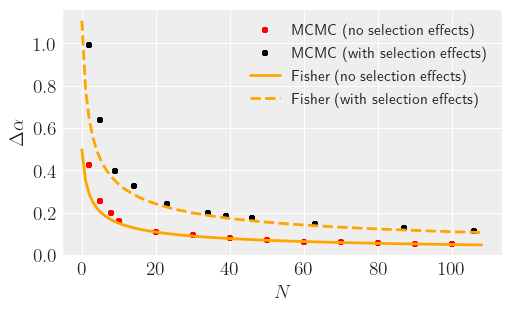

In [13]:
# Obtained without selection effects with tutorial code.
N_mcmc_nosel = [2, 5, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
widths_mcmc_nosel = [0.4241413342171043, 0.2564915824737737, 0.19752499334909973, 0.16086199517143002, 
                     0.1098834936814631, 0.09283415521246546, 0.08025321201940053, 0.07209979572140537, 
                     0.0618071927857337, 0.0610174386988298, 0.05645250676195151, 0.052183028854714396,  
                     0.05063649210478289]


# Obtained with selection effects.

N_det_sel = [2, 5, 9, 14, 23, 34, 39, 46, 63, 87, 106]
widths_det_sel = [0.9912795643418902, 0.6374698584526438, 0.39456644966942866, 0.32650555806905796, 
                  0.2418621186948156, 0.1974904356207184, 0.18335640153054675, 0.17326842742425752, 
                  0.14698104815678012, 0.12609283240058017, 0.11159709023169541]


## Plot

fig, ax = plt.subplots(1,1,figsize=(5,3))

# MCMC results
plt.scatter(N_mcmc_nosel,widths_mcmc_nosel,c='red', marker='+', lw=3, label='MCMC (no selection effects)')
plt.scatter(N_det_sel,widths_det_sel,c='black', marker='+', lw=3, label='MCMC (with selection effects)')

# Fisher predictions
plt.plot(Da_list,c='orange',lw=2, label='Fisher (no selection effects)')
plt.plot(Da_list_sel,c='orange', ls='--',lw=2, label='Fisher (with selection effects)')

plt.xlabel('$N$')
plt.ylabel('$\Delta\\alpha$')
plt.legend(loc='best')

plt.savefig('Da_vs_N.pdf')

We note that the Fisher prediction agrees remarkably well for sufficiently high observations $N\geq 10$ without selection effects, even if we are only retaining the first term in the Fisher matrix. 

A similar level of agreement is there also in the case with selection effects.